In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar la base limpia que generamos en la etapa de limpieza
#    Nota: df_cleaned.csv debe estar en la misma carpeta del script/notebook
df = pd.read_csv("df_cleaned.csv")

Shape del dataset: (20827, 105)

Primeras filas del dataset:
   host_since  host_response_time  host_response_rate  host_acceptance_rate  \
0  2019-12-14  within a few hours                 100                  54.0   
1  2013-01-19        within a day                  90                  69.0   
2  2019-09-16  within a few hours                  75                 100.0   
3  2014-04-29        Sin registro                 100                  60.0   
4  2013-07-25  a few days or more                   0                   0.0   

    latitude  longitude  accommodates  bathrooms  bathrooms_text  bedrooms  \
0  40.746980 -73.917630             1        1.0   1 shared bath       1.0   
1  40.721470 -73.982700             1        2.0  2 shared baths       1.0   
2  40.682300 -73.845450             6        1.0          1 bath       2.0   
3  40.713163 -73.943077             1        1.0   1 shared bath       2.0   
4  40.674120 -73.941230             6        4.0         4 baths       3.0

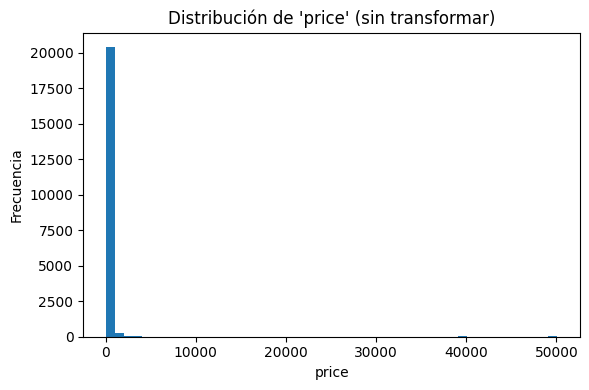

In [ ]:
# Revisar tamaño del dataset (filas, columnas) para tener una idea del orden de magnitud
print("Shape del dataset:", df.shape)

# Ver las primeras filas para confirmar que las columnas corresponden a lo esperado
print("\nPrimeras filas del dataset:")
print(df.head())

# Revisar tipos de datos para tener claro qué es numérico, categórico, etc.
print("\nResumen de tipos de datos:")
print(df.dtypes)

# Descripción básica de la variable objetivo original 'price'
#    Esto ayuda a ver rangos, promedio, percentiles, etc.
print("\nDescripción estadística de 'price':")
print(df["price"].describe())

# Histograma de 'price' sin transformar
#    La idea es visualizar la distribución cruda y ver si está muy sesgada
plt.figure(figsize=(6, 4))
plt.hist(df["price"], bins=50)
plt.title("Distribución de 'price' (sin transformar)")
plt.xlabel("price")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()